# ideas:
- continue tweaking the model parameters
- look at predictions and see if all classes are mispredicted
- do feature selection based on plots, feature importances
- stack two models: functional vs non functional, needs repair vs does not need repairs
- for features with a lot of levels, collapse them into "other" or "unknown"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV

# data loading, preparing CV

In [2]:
train = pd.read_csv('../../data/processed/train.csv', index_col=0)
train_labels = pd.read_csv('../../data/processed/train_labels.csv', index_col=0)

train.shape

(59400, 65)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, random_state=42)
print(X_train.shape)
print(X_test.shape)

(44550, 65)
(14850, 65)


In [4]:
cv = StratifiedKFold(n_splits=5, random_state=42)

C:\Users\silvia\anaconda3\envs\pumpitup\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


# models
## random forest classifier

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
clf = RandomForestClassifier(bootstrap=True, random_state=42)

parameter_grid = {
    'n_estimators': [80, 85, 90, 95, 100, 110, 120, 130, 140, 150],
    'max_depth': [16, 18, 19, 20, 21, 22, 24],
}

random_search = RandomizedSearchCV(clf, parameter_grid, cv=cv)

In [13]:
random_search.fit(X_train, y_train)

C:\Users\silvia\anaconda3\envs\pumpitup\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\silvia\anaconda3\envs\pumpitup\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\silvia\anaconda3\envs\pumpitup\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\silvia\anaconda3\envs\pumpitup\lib\site-packages\sklearn\model_selection\_va

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_spli...
                     

In [14]:
print(random_search.best_params_, random_search.best_score_)

{'n_estimators': 150, 'max_depth': 20} 0.8042648709315376


## xgboost

In [5]:
import xgboost as xgb

In [6]:
y_dict = {'functional': 0,
          'non functional': 1,
          'functional needs repair': 2}

y_train_num = y_train.status_group.map(y_dict)

dtrain = xgb.DMatrix(X_train, label=y_train_num)

In [7]:
# fixed xgb params
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'enable_experimental_json_serialization': True
}

# params to be optimized
parameter_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 8, 12, 15]
        }

clf = xgb.XGBClassifier(params)

random_search = RandomizedSearchCV(clf, parameter_grid, cv=cv)

In [18]:
random_search.fit(X_train, y_train)

C:\Users\silvia\anaconda3\envs\pumpitup\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\silvia\anaconda3\envs\pumpitup\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth={'num_class': 3,
                                                      'objective': 'multi:softmax'},
                                           min_child_weight=1, missing=None,
                                           n_estimator...
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   ii

In [19]:
print(random_search.best_params_, random_search.best_score_)

{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 15, 'gamma': 1, 'colsample_bytree': 0.8} 0.8072502805836139


In [8]:
best = random_search.best_estimator_

# best = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#                          colsample_bynode=1, colsample_bytree=0.8, gamma=1,
#                          learning_rate=0.1, max_delta_step=0, max_depth=15,
#                          min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
#                          nthread=None, objective='multi:softprob', random_state=0,
#                          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#                          silent=None, subsample=0.6, verbosity=1, enable_experimental_json_serialization=True)

best.fit(train, train_labels)

C:\Users\silvia\anaconda3\envs\pumpitup\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\silvia\anaconda3\envs\pumpitup\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_experimental_json_serialization=True, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [15]:
params.update(best.get_xgb_params())
params

{'objective': 'multi:softprob',
 'num_class': 3,
 'enable_experimental_json_serialization': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 15,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 0.6,
 'verbosity': 1}

In [17]:
booster = xgb.train(params, dtrain)

In [18]:
booster.save_model('200401_model.bin')

In [21]:
y_pred = best.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8076767676767677

# make predictions

In [23]:
external = pd.read_csv('../../data/processed/test.csv', index_col=0)

final_pred = best.predict(external)

In [24]:
out = pd.DataFrame(index=external.index)
out['status_group'] = final_pred

out.head()

status_group
id                   
50785  non functional
51630      functional
17168      functional
45559  non functional
49871      functional

### xgb, feature selection

try to improve model performance by dropping features with low weights

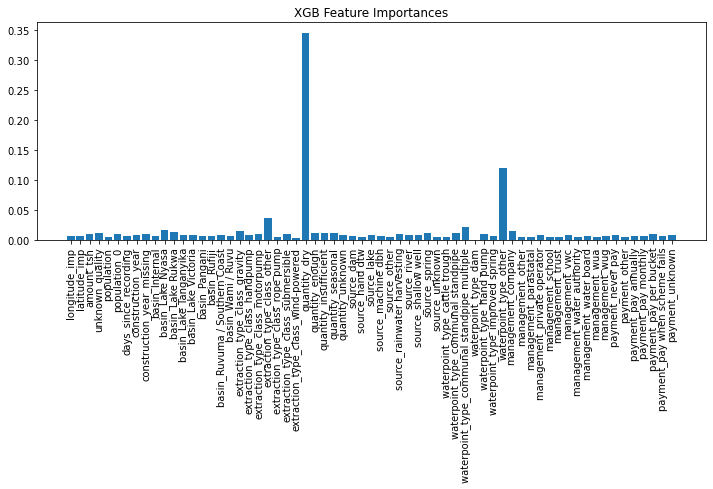

In [68]:
importances = pd.Series(data=best.feature_importances_, index=X_train.columns)

plt.figure(figsize=(12,4))
plt.bar(range(importances.shape[0]), importances)
plt.xticks(ticks=range(importances.shape[0]), labels=importances.index, rotation=90)
plt.title('XGB Feature Importances')
plt.show()

In [69]:
# top features
top50 = importances.sort_values(ascending=False)[:50].index
importances.sort_values(ascending=False)[:50]

quantity_dry                                   0.346201
waterpoint_type_other                          0.119571
extraction_type_class_other                    0.037220
waterpoint_type_communal standpipe multiple    0.021173
basin_Lake Nyasa                               0.016916
management_company                             0.015436
extraction_type_class_gravity                  0.014219
basin_Lake Rukwa                               0.013559
unknown_quality                                0.012046
quantity_seasonal                              0.011873
quantity_enough                                0.011158
source_spring                                  0.011115
waterpoint_type_communal standpipe             0.010864
quantity_insufficient                          0.010629
source_rainwater harvesting                    0.010502
waterpoint_type_hand pump                      0.010476
amount_tsh                                     0.010141
extraction_type_class_motorpump                0

In [70]:
# fixed xgb params
params = {
    'objective': 'multi:softmax',
    'num_class': 3
}

# params to be optimized
parameter_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 8, 12, 15]
        }

clf = xgb.XGBClassifier(params)

random_search = RandomizedSearchCV(clf, parameter_grid, cv=cv)

In [71]:
random_search.fit(X_train[top50], y_train)

C:\Users\silvia\anaconda3\envs\pumpitup\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\silvia\anaconda3\envs\pumpitup\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth={'num_class': 3,
                                                      'objective': 'multi:softmax'},
                                           min_child_weight=1, missing=None,
                                           n_estimator...
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   ii

In [72]:
print(random_search.best_params_, random_search.best_score_)

{'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 15, 'gamma': 1, 'colsample_bytree': 0.8} 0.8023569023569024


In [76]:
best = random_search.best_estimator_

best.fit(train[top50], train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [78]:
y_pred = best.predict(X_test[top50])

In [79]:
accuracy_score(y_test, y_pred)

0.8028956228956229

In [80]:
external = pd.read_csv('../../data/processed/test.csv', index_col=0)

final_pred = best.predict(external[top50])

In [81]:
out = pd.DataFrame(index=external.index)
out['status_group'] = final_pred

out.head()

status_group
id                   
50785  non functional
51630      functional
17168      functional
45559  non functional
49871      functional